In [373]:
import numpy as np 
import polars as pl #(I was having a personal dilemma as I have always used pandas... but polars performance is out of this world)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random

# **"A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E.”**
That's it :D chapter finished

# Machine learning basics
This chapter is where it starts to be really difficult for me (a little bit) as the theoretical background of the book is impecable, but any example that I give you is going to make you not consider other things... so this is what I am going to do... I am going to use 4 examples
1. A random generated set that focus on two subsets distributed randomly over two focus points (don't worry I will explained little by little :D)
2. A dataset of the price of diamonds based on characteristics([Diamonds Dataset](https://www.kaggle.com/datasets/shivam2503/diamonds))
3. A very famous set of pictures called CIFAR-10 (learn a little bit more about them in [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html))
4. A set of handwritten digits called MNIST (learn a little bit more about them in [MNIST](http://yann.lecun.com/exdb/mnist/))
 
Remember is always good to properly cite your data!!!( I will do so when the project is done but until then hehe you have the links).

I have place them in order on how difficulty I think it is to work on them and what we should need to consider in order to get good results. But until the next chapter this will more than enough. Before we start let's check out our data

# Dataset 1 (Random points)

In [177]:
# This part of the code is only to create the data for the random points and save it in a csv
# generate_random_dataset
# arguments:
# points = 2 (number of focus points of you dataset)
def generate_random_dataset(focus=2,n=400):
    points = []
    df = pl.DataFrame({"x":[],"y":[],"c":[]})
    df = df.select(
            pl.col("x").cast(pl.Float64).alias("x"),
            pl.col("y").cast(pl.Float64).alias("y"),
            pl.col("c").cast(pl.Int64).alias("c")
         )
    for _ in range(focus):
        x = random.uniform(-8,8 )
        y = random.uniform(-8,8 )
        points.append((x, y))
    for _ in range(n):
        choosed = np.random.choice([0,1])
        p = points[choosed]
        x = np.random.normal()
        y = np.random.normal()
        dn = pl.DataFrame({"x":[x+p[0]],"y":[y+p[1]],"c":[choosed]})
        df = pl.concat([df,dn])
    df.write_csv("datasets/random_points.csv")

In [187]:
dataset = pl.read_csv("datasets/random_points.csv") #this is the important part
print(dataset.head())
data = dataset.to_numpy()

shape: (5, 3)
┌───────────┬───────────┬─────┐
│ x         ┆ y         ┆ c   │
│ ---       ┆ ---       ┆ --- │
│ f64       ┆ f64       ┆ i64 │
╞═══════════╪═══════════╪═════╡
│ 2.618677  ┆ 1.616839  ┆ 1   │
│ 1.366612  ┆ 0.85761   ┆ 1   │
│ -0.242673 ┆ -8.444032 ┆ 0   │
│ 0.801606  ┆ 2.803869  ┆ 1   │
│ -0.483904 ┆ -7.338172 ┆ 0   │
└───────────┴───────────┴─────┘


We are going to plot it to see what this is 

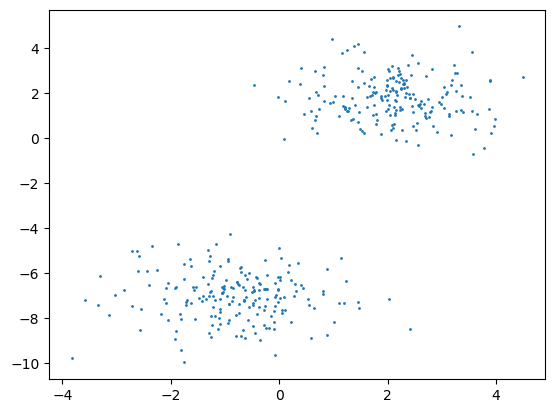

In [188]:
plt.scatter([i[0] for i in data] ,[i[1] for i in data],s=1)

This is the data set that we are working on... it is clear on what we are going to do... but please, we haven't actually set up any objective, until we have more tools, this is just data, nothing else. 

# Dataset 2
For this we are going to use kaggle ([Kaggle](https://www.kaggle.com/datasets/shivam2503/diamonds?resource=download)), kaggle is a platform where you can find challeges and many datasets!

In [189]:
dataset = pl.read_csv("datasets/diamonds.csv") 
print(dataset.head())
data = dataset.to_numpy()

shape: (5, 11)
┌─────┬───────┬─────────┬───────┬───┬───────┬──────┬──────┬──────┐
│     ┆ carat ┆ cut     ┆ color ┆ … ┆ price ┆ x    ┆ y    ┆ z    │
│ --- ┆ ---   ┆ ---     ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ i64 ┆ f64   ┆ str     ┆ str   ┆   ┆ i64   ┆ f64  ┆ f64  ┆ f64  │
╞═════╪═══════╪═════════╪═══════╪═══╪═══════╪══════╪══════╪══════╡
│ 1   ┆ 0.23  ┆ Ideal   ┆ E     ┆ … ┆ 326   ┆ 3.95 ┆ 3.98 ┆ 2.43 │
│ 2   ┆ 0.21  ┆ Premium ┆ E     ┆ … ┆ 326   ┆ 3.89 ┆ 3.84 ┆ 2.31 │
│ 3   ┆ 0.23  ┆ Good    ┆ E     ┆ … ┆ 327   ┆ 4.05 ┆ 4.07 ┆ 2.31 │
│ 4   ┆ 0.29  ┆ Premium ┆ I     ┆ … ┆ 334   ┆ 4.2  ┆ 4.23 ┆ 2.63 │
│ 5   ┆ 0.31  ┆ Good    ┆ J     ┆ … ┆ 335   ┆ 4.34 ┆ 4.35 ┆ 2.75 │
└─────┴───────┴─────────┴───────┴───┴───────┴──────┴──────┴──────┘


As you might see... it is imposible for us to graph this... as we have many many Features, what are attributes? well good question... we can start our definition 
### Dataset, objects, features, attributes
A dataset is set that contains objects, objects, as we will call all rows in a dataset, are instances of infomrmation that share a number of characteristics, this characteristics are what we called a feature, meaning a feature is something that characterize a set of objects in a dataset. And the attribute is the value of that feature inside an object. That is a toungue twister hehe, using the example above. the first row represent an object (in this case a diamond), a row is a feature (an example is color, meaning color is a feature of a diamond) and finally an atrribute is the value that characterises the object with respect a feature (meaning for example E in the feature color of the first diamond).

_Was this definition necessary? No... but I have to self promote a bit, I worked on a paper that makes a new way of understanding the relation between features, so I usually use this definitions when talking about machine learning you should read it after you finish the book... I am no expert but is quite good :D_

We cannot visualize all of them but we can do something interesting, we can take two of the features and then graph their relationship. Only focusing on that features :D

In [218]:
#First let's get the features
features = [i.name  for i in dataset.get_columns() if i.name != ""]
print(f"features = {features}")
#First let's get the features
types = [i.dtype  for i in dataset.get_columns() if i.name != ""]
print(f"types = {types}")

features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
types = [Float64, String, String, String, Float64, Float64, Int64, Float64, Float64, Float64]


In [ ]:
# We are going to create a function that takes two of this features and graph the relation

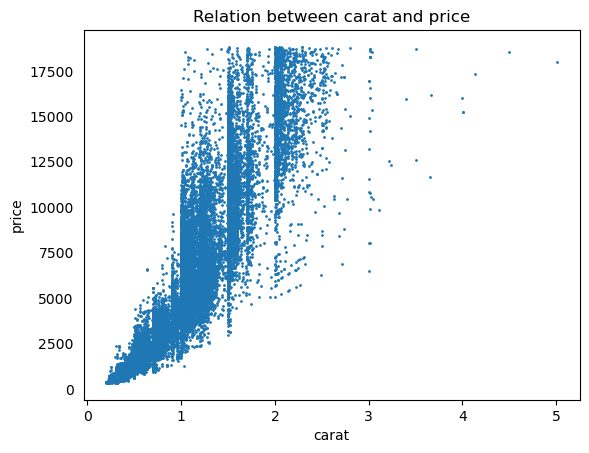

In [265]:
fig = plt.figure()
ax = fig.add_subplot()
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,        # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
def plot_relation_between_to_features(f1,f2,fig,ax,title=True,label_x=True,label_y=True):
    x = dataset.get_column(f1).to_numpy()
    y = dataset.get_column(f2).to_numpy()
    ax.scatter(x,y,s=1)
    if(label_x):
        ax.set_xlabel(f1)
    if(label_y):
        ax.set_ylabel(f2)
    if(title):
        ax.set_title(f"Relation between {f1} and {f2}")
plot_relation_between_to_features("carat","price",fig,ax)

Really nice right? We are going to do the same for all data that is a number... at first we are going to only do this because until now we haven't even met a case of categorical data and we don't even now what to do when we have an attribute that says Premium... how do you multiply Premium times 2... We are going to learn it just a little bit latter

In [235]:
numerical_features = [i  for i in features if dataset.get_column(i).dtype in [pl.Float64,pl.Int64]]
print(f"numerical_features = {numerical_features}")

numerical_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


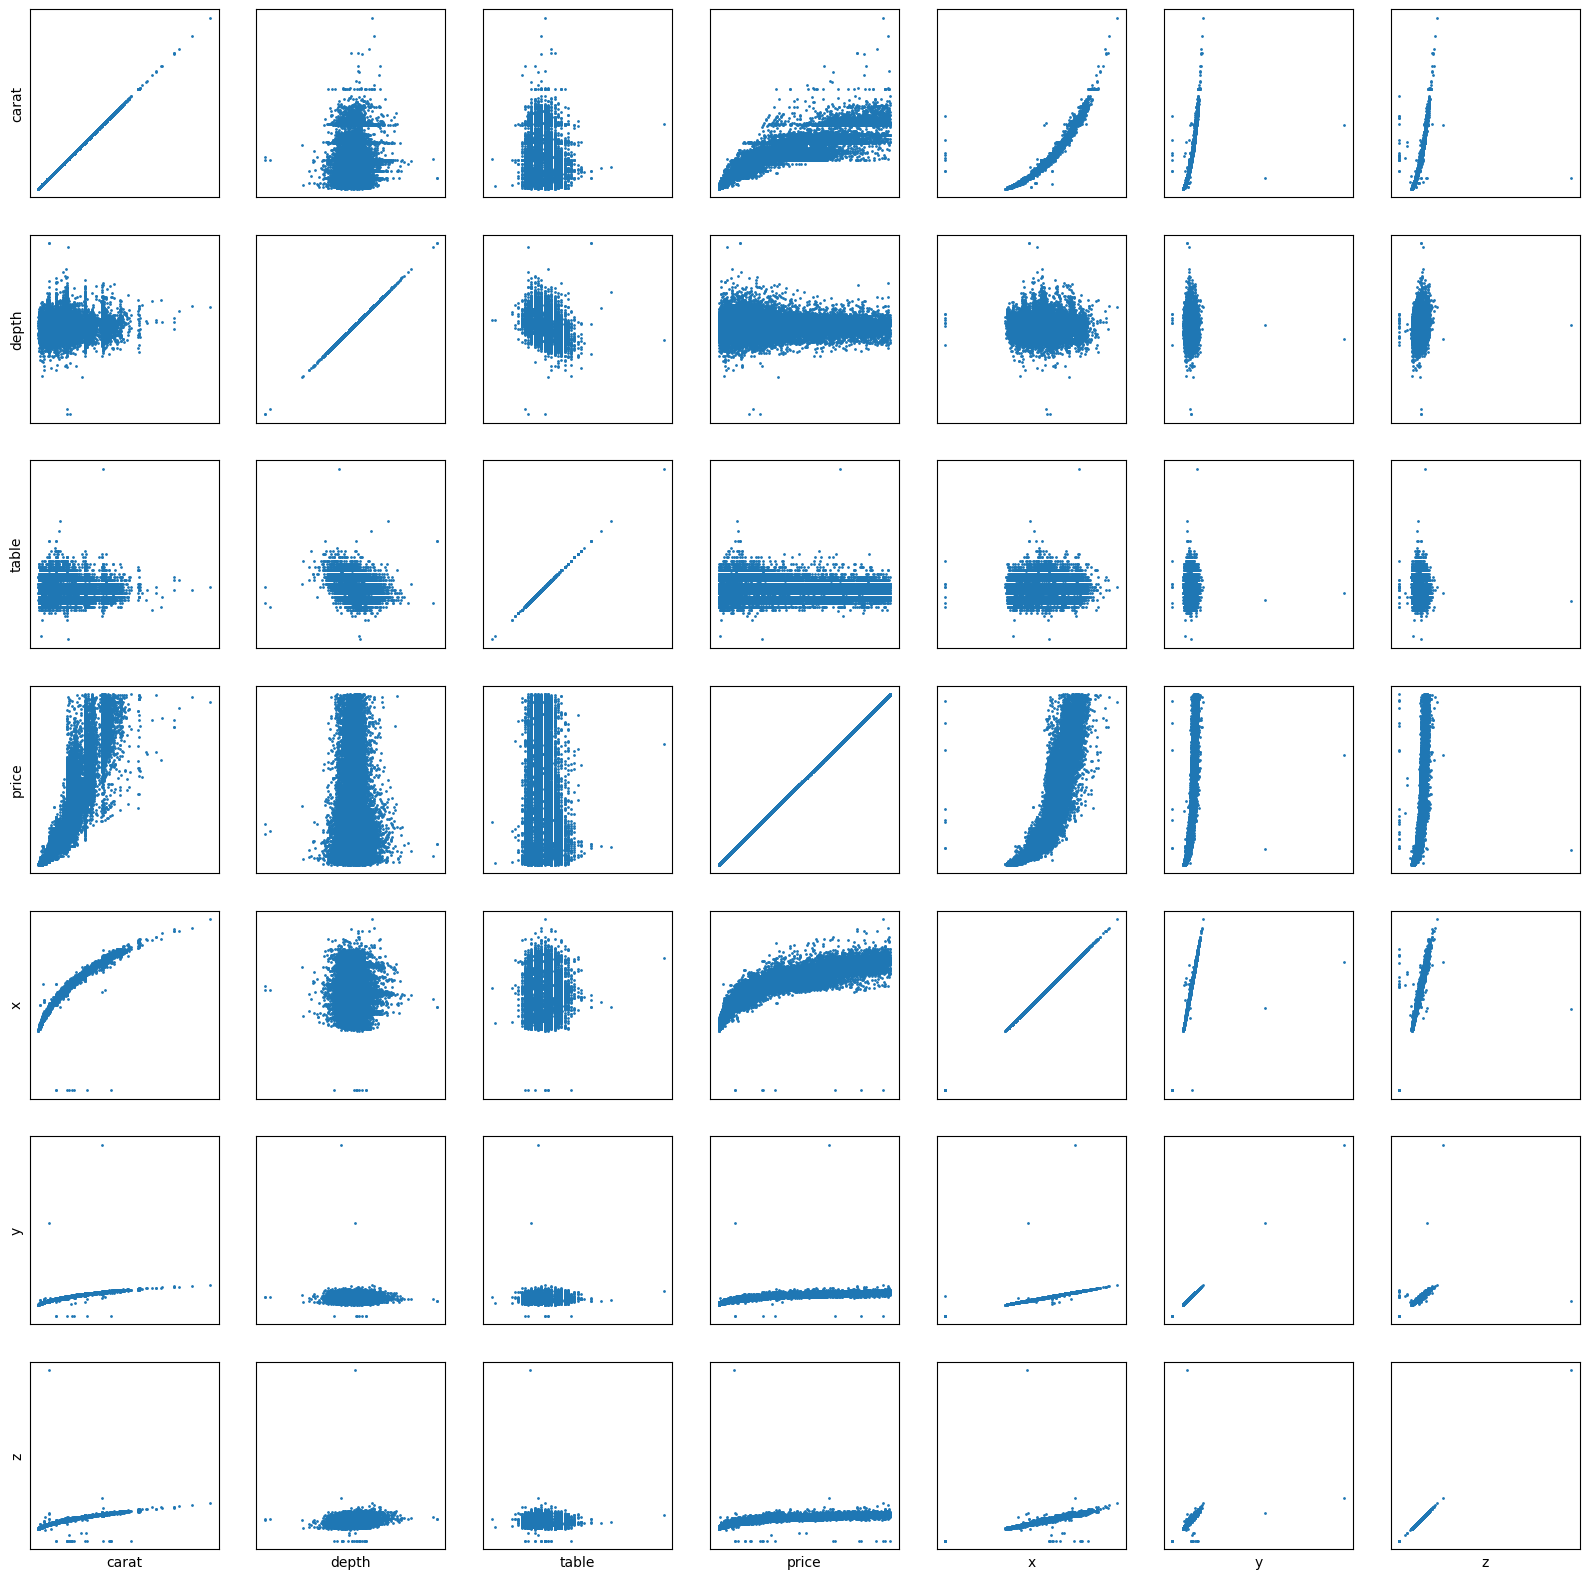

In [266]:
fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(20,20))
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i][j]
        ax.set_xticks([])
        ax.set_yticks([])
        label_x = i==len(numerical_features)-1
        label_y = j==0
        plot_relation_between_to_features(numerical_features[j],numerical_features[i],fig,ax,title=False,label_x=label_x,label_y=label_y)

Nice right? so well that is our dataset

# Dataset 3

In [396]:
dataset = tf.keras.datasets.mnist.load_data()

In [397]:
images = dataset[1][0]
categories = dataset[1][1]

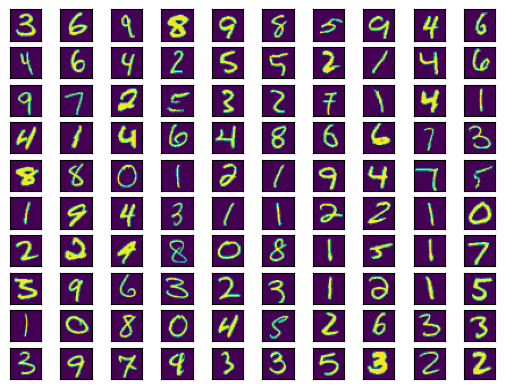

In [398]:
fig, *ax = plt.subplots(nrows=10,ncols=10)
axes = ax[0]
for i in range(10):
    for j in range(10):
        a = np.random.randint(0,1000)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].imshow(images[a])
plt.show()

# Dataset 4
We are going to start using tensor flow... until what we have, we actually don't have knowledge of tensor flow or what is even a tensor... but well, tensor flow library has a submodule of datasets, that is going to be very useful right now :D

In [269]:
# To download data
dataset = tf.keras.datasets.cifar10.load_data()

In [360]:
#In this dataset we have the images and the categories it has
images = dataset[1][0]
categories = dataset[1][1]

In [361]:
print(images.shape)
print(categories.shape)

(10000, 32, 32, 3)
(10000, 1)


We have then 10000 images of 3 layers (RGB) and each layer 32 by 32 pixels, let's see an image

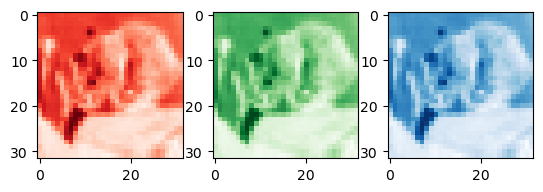

In [314]:
#First image
fig,ax = plt.subplots(ncols=3)
ax[0].imshow(images[0][:,:,0],cmap="Reds")
ax[1].imshow(images[0][:,:,0],cmap="Greens")
ax[2].imshow(images[0][:,:,0],cmap="Blues")
#If you are daltonic, I'm sorry the next example will work better for you

Cool that is clearly a...hmmm... 

In [315]:
print(categories[0])

[3]


That is clearly a category 3 hehe, each image have this layers, because when you overlay those three images you can get all colors that a computer can handle, thus if we plot the whole image

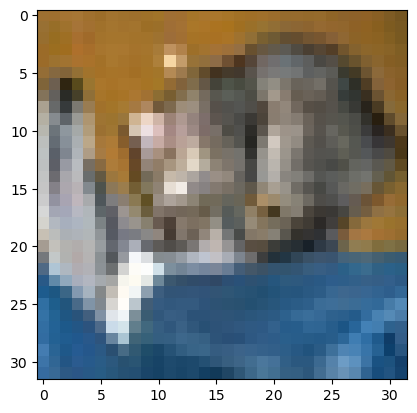

In [316]:
plt.imshow(images[0])

In [ ]:
#Let plot more figures of each category

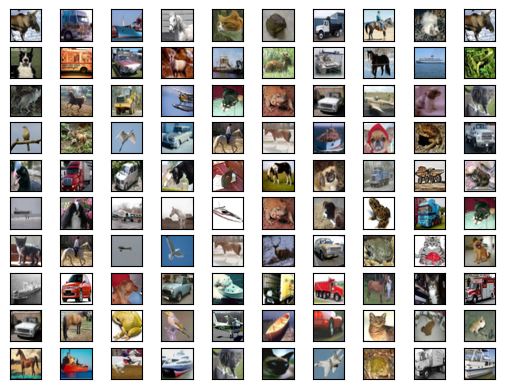

In [387]:
fig, *ax = plt.subplots(nrows=10,ncols=10)
axes = ax[0]
for i in range(10):
    for j in range(10):
        a = np.random.randint(0,1000)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].imshow(images[a])
plt.show()

We are going to look further in the next steps.